In [1]:
import pandas as pd
import pubchempy as pcp
from tqdm.auto import tqdm
import numpy as np
import itertools
from lib.descriptor_gen import DescriptorGen
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from pingouin import wilcoxon, plot_paired
import joblib

tqdm.pandas()

c:\Users\ewert\anaconda3\envs\aitox_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
# Install packages from requirements
#! pip install --no-cache-dir -r requirements.txt

### Load data

In [2]:
df = pd.read_csv("data/AID_1645841_datatable.csv",skiprows=[1,2,3,4,5],low_memory=False)
df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033.0,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670.0,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832.0,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443.0,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836.0,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,5238,90341041,11957637.0,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5238,5239,90341069,4906.0,CCCNC(C)C(=O)NC1=CC=CC=C1C,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5239,5240,90341160,5593.0,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,Active,42,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5240,5241,90341654,2968.0,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,1.3450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Verify NaN PUBCHEM_CID and remove

In [3]:
sum(df.PUBCHEM_CID.isna())

3

In [4]:
df[df.PUBCHEM_CID.isna()]

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
173,174,144206496,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,1499,170465762,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2886,2887,225144377,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dropna(subset=["PUBCHEM_CID"],inplace=True)
sum(df.PUBCHEM_CID.isna())

0

### Convert PUBCHEM_CID column to integer

In [6]:
df.PUBCHEM_CID = df.PUBCHEM_CID.astype(int)

In [7]:
df.dtypes

PUBCHEM_RESULT_TAG                    int64
PUBCHEM_SID                           int64
PUBCHEM_CID                           int32
PUBCHEM_EXT_DATASOURCE_SMILES        object
PUBCHEM_ACTIVITY_OUTCOME             object
                                     ...   
Activity at 23.94 uM-Replicate_5    float64
Activity at 57.45 uM-Replicate_5    float64
Activity at 115.4 uM-Replicate_5    float64
Activity at 193.5 uM-Replicate_5    float64
Activity at 288.3 uM-Replicate_5    float64
Length: 204, dtype: object

### Convert labels

In [8]:
labels = df['Phenotype-Replicate_1'].unique().tolist()

le = LabelEncoder()
df['label'] = le.fit_transform(df['Phenotype-Replicate_1'])

### Define reference PUBCHEM data 

In [28]:
data_df = df[['PUBCHEM_CID','PUBCHEM_EXT_DATASOURCE_SMILES','Phenotype-Replicate_1','label']].copy()
data_df

,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,Phenotype-Replicate_1,label
0,197033,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Inhibitor,2
1,5281670,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,1
2,6604832,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,Inhibitor,2
3,5280443,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Inhibitor,2
4,836,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Inhibitor,2
...,...,...,...,...
5237,11957637,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,Inactive,1
5238,4906,CCCNC(C)C(=O)NC1=CC=CC=C1C,Inactive,1
5239,5593,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,Inhibitor,2
5240,2968,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,Inhibitor,2


### Download SMILES from PUBCHEM

In [29]:
cmpd_list = []
num_chunks = len(df)/100
for chunk in tqdm(np.array_split(data_df.PUBCHEM_CID,num_chunks)):
    cmpd_list.append(pcp.get_compounds(chunk.tolist()))

data_df['Compound'] = list(itertools.chain(*cmpd_list))

data_df['SMILES'] = [x.canonical_smiles for x in data_df.Compound]

100%|██████████| 52/52 [03:51<00:00,  4.46s/it]


In [35]:
data_df = data_df[['PUBCHEM_CID','PUBCHEM_EXT_DATASOURCE_SMILES', 'SMILES','Phenotype-Replicate_1','label']]
data_df 

,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,SMILES,Phenotype-Replicate_1,label
0,197033,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Inhibitor,2
1,5281670,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,1
2,6604832,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,CC1C(C(=O)NC(C(=O)N2CCCC2C(=O)N(CC(=O)N(C(C(=O...,Inhibitor,2
3,5280443,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Inhibitor,2
4,836,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Inhibitor,2
...,...,...,...,...,...
5237,11957637,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,C=CCN1CCC23C4C(=O)CCC2(C1CC5=C3C(=C(C=C5)O)O4)O,Inactive,1
5238,4906,CCCNC(C)C(=O)NC1=CC=CC=C1C,CCCNC(C)C(=O)NC1=CC=CC=C1C,Inactive,1
5239,5593,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,Inhibitor,2
5240,2968,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,Inhibitor,2


### Calculate descriptors

In [37]:
desc_gen = DescriptorGen()

data_df['desc'] = data_df.SMILES.progress_apply(desc_gen.from_smiles)

  0%|          | 0/5239 [00:00<?, ?it/s][14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRECATION WARNING: please use MorganGenerator
[14:59:49] DEPRE

### Split the data into training and test sets

In [130]:
train, test = train_test_split(data_df)
train_X = np.stack(train.desc)
train_y = train.label
test_X = np.stack(test.desc)
test_y = test.label

### Use oversampling to compensate for imbalanced data

In [131]:
ros = RandomOverSampler()
resample_X, resample_y = ros.fit_resample(train_X,train_y)

In [48]:
before = pd.Series(train_y).value_counts()
after = pd.Series(resample_y).value_counts()

print(f'Before resample \n{before}\n')
print(f'After resample \n{after}')

Before resample 
label
2    2283
1    1393
0     253
Name: count, dtype: int64

After resample 
label
0    2283
1    2283
2    2283
Name: count, dtype: int64


### Traning models

In [103]:
def LGB(X,y):

    model = LGBMClassifier(random_state=np.random.randint(1, 100))
    model.fit(X, y)

    return model

In [51]:
# Training standard model
model = LGB(train_X,train_y)
pred = model.predict_proba(test_X)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,036563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9171
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1626
[LightGBM] [Info] Start training from score -2,742751
[LightGBM] [Info] Start training from score -1,036925
[LightGBM] [Info] Start training from score -0,542895


In [88]:
# Training resampled model
model_rs = LGB(resample_X,resample_y)
pred_rs = model_rs.predict_proba(test_X)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,041151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9723
[LightGBM] [Info] Number of data points in the train set: 6849, number of used features: 1900
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


### Evaluating Standard Model

In [53]:
roc_auc_score(test_y,pred,multi_class='ovo',average='macro')

0.7671314477035205

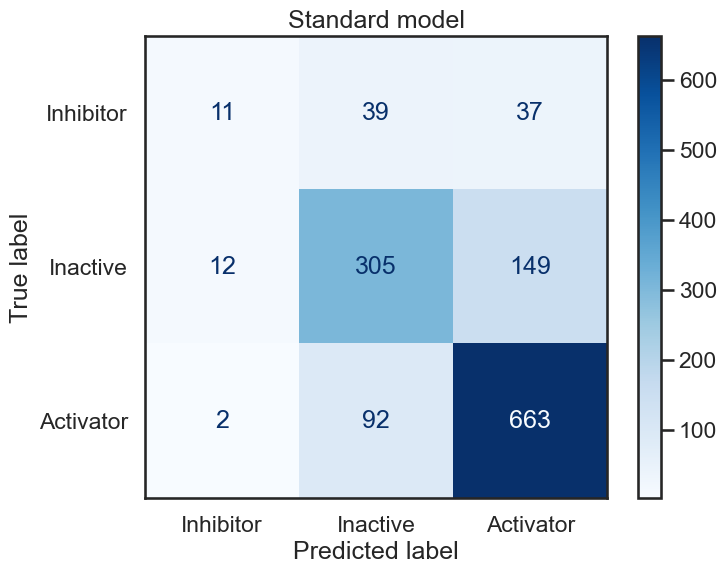

In [81]:
labels = data_df['Phenotype-Replicate_1'].unique().tolist()

sns.set_style("white")
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (8,6)
disp = ConfusionMatrixDisplay.from_estimator(model, test_X, test_y, display_labels=labels, cmap=plt.cm.Blues)

plt.title("Standard model");

### Evaluating Oversampled Model

In [89]:
roc_auc_score(test_y,pred_rs,multi_class='ovr',average='macro')

0.7905273015676523

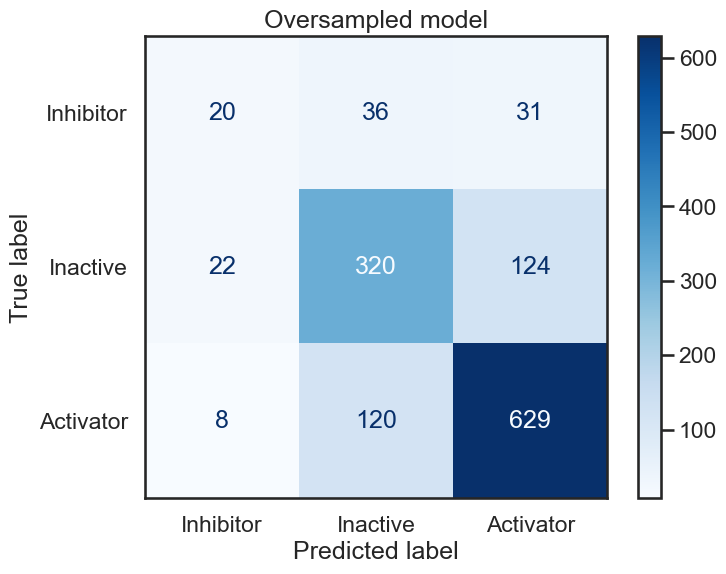

In [82]:
labels = data_df['Phenotype-Replicate_1'].unique().tolist()

sns.set_style("white")
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (8,6)
disp = ConfusionMatrixDisplay.from_estimator(model_rs, test_X, test_y, display_labels=labels, cmap=plt.cm.Blues)

plt.title("Oversampled model");

### Comparing models

In [110]:
res = []
for i in tqdm(range(0,10)):
    # split the data into training and test sets
    train, test = train_test_split(data_df)
    train_X = np.stack(train.desc)
    train_y = train.label
    test_X = np.stack(test.desc)
    test_y = test.label
    # Create the standard model
    lgbm = LGBMClassifier()
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict_proba(test_X)
    auc = roc_auc_score(test_y,pred,multi_class='ovo',average='macro')
    # Create the resampled model
    resample_lgbm = LGBMClassifier()
    resample_X, resample_y = ros.fit_resample(train_X,train_y)
    resample_lgbm.fit(resample_X, resample_y)
    resample_pred = resample_lgbm.predict_proba(test_X)
    resample_auc = roc_auc_score(test_y,resample_pred,multi_class='ovr',average='macro')
    res.append([auc, resample_auc])

res = np.array(res)
res_df = pd.DataFrame(res,columns=["Standard","Oversampled"])

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,035712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1627
[LightGBM] [Info] Start training from score -2,681429
[LightGBM] [Info] Start training from score -1,050659
[LightGBM] [Info] Start training from score -0,541581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,033981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9748
[LightGBM] [Info] Number of data points in the train set: 6858, number of used features: 1908
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 10%|█         | 1/10 [00:05<00:47,  5.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,032146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9155
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1614
[LightGBM] [Info] Start training from score -2,719312
[LightGBM] [Info] Start training from score -1,036925
[LightGBM] [Info] Start training from score -0,545526
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,038209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9724
[LightGBM] [Info] Number of data points in the train set: 6831, number of used features: 1898
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 20%|██        | 2/10 [00:11<00:44,  5.59s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,041033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9191
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1633
[LightGBM] [Info] Start training from score -2,730963
[LightGBM] [Info] Start training from score -1,034058
[LightGBM] [Info] Start training from score -0,545965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,040086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9723
[LightGBM] [Info] Number of data points in the train set: 6828, number of used features: 1901
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 30%|███       | 3/10 [00:15<00:36,  5.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,043940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9176
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1630
[LightGBM] [Info] Start training from score -2,799677
[LightGBM] [Info] Start training from score -1,045577
[LightGBM] [Info] Start training from score -0,531570
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,037122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9719
[LightGBM] [Info] Number of data points in the train set: 6927, number of used features: 1903
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 40%|████      | 4/10 [00:21<00:31,  5.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,024967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9177
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1630
[LightGBM] [Info] Start training from score -2,685153
[LightGBM] [Info] Start training from score -1,054304
[LightGBM] [Info] Start training from score -0,538960
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,034745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 6876, number of used features: 1919
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 50%|█████     | 5/10 [00:25<00:23,  4.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,032456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9181
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1626
[LightGBM] [Info] Start training from score -2,685153
[LightGBM] [Info] Start training from score -1,035491
[LightGBM] [Info] Start training from score -0,550369
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,037547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9689
[LightGBM] [Info] Number of data points in the train set: 6798, number of used features: 1883
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 60%|██████    | 6/10 [00:29<00:18,  4.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,038701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9151
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1619
[LightGBM] [Info] Start training from score -2,703986
[LightGBM] [Info] Start training from score -1,031913
[LightGBM] [Info] Start training from score -0,550369
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,033429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9712
[LightGBM] [Info] Number of data points in the train set: 6798, number of used features: 1897
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 70%|███████   | 7/10 [00:33<00:13,  4.53s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,023173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9189
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1635
[LightGBM] [Info] Start training from score -2,746711
[LightGBM] [Info] Start training from score -1,036208
[LightGBM] [Info] Start training from score -0,542895
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,037959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9710
[LightGBM] [Info] Number of data points in the train set: 6849, number of used features: 1894
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 80%|████████  | 8/10 [00:38<00:08,  4.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,040729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9178
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1627
[LightGBM] [Info] Start training from score -2,746711
[LightGBM] [Info] Start training from score -1,021255
[LightGBM] [Info] Start training from score -0,552136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,032287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9733
[LightGBM] [Info] Number of data points in the train set: 6786, number of used features: 1905
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


 90%|█████████ | 9/10 [00:42<00:04,  4.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,016873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9179
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1626
[LightGBM] [Info] Start training from score -2,742751
[LightGBM] [Info] Start training from score -1,034058
[LightGBM] [Info] Start training from score -0,544648
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,023922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9735
[LightGBM] [Info] Number of data points in the train set: 6837, number of used features: 1898
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


In [111]:
res_df.head()

,Standard,Oversampled
0,0.758891,0.780865
1,0.734694,0.768679
2,0.721691,0.764611
3,0.752539,0.787891
4,0.737257,0.763385


In [112]:
melt_df = res_df.melt()
melt_df.columns = ["Method","AUC"]
melt_df

,Method,AUC
0,Standard,0.758891
1,Standard,0.734694
2,Standard,0.721691
3,Standard,0.752539
4,Standard,0.737257
5,Standard,0.727411
6,Standard,0.736256
7,Standard,0.719084
8,Standard,0.764480
9,Standard,0.736816


<Axes: xlabel='AUC', ylabel='Density'>

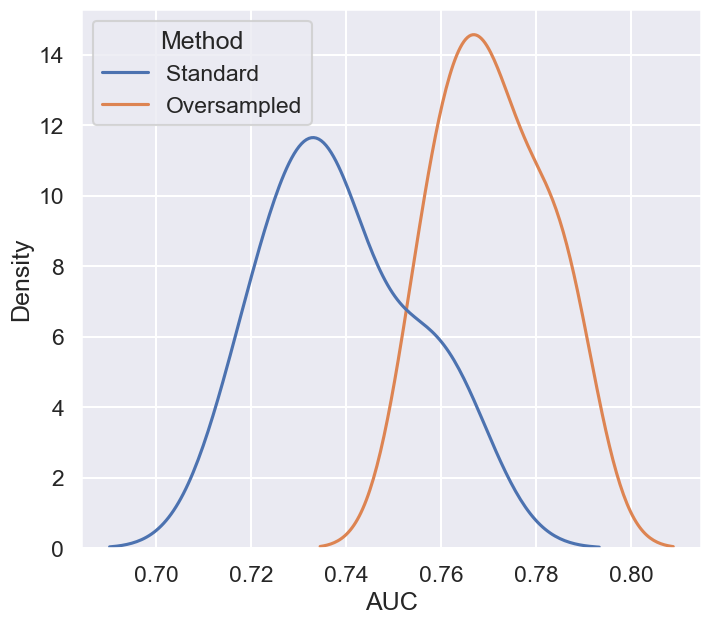

In [122]:
sns.set(rc={'figure.figsize': (8, 7)})
sns.set_context('talk')
sns.kdeplot(x="AUC",hue="Method",data=melt_df)

### Statistic test

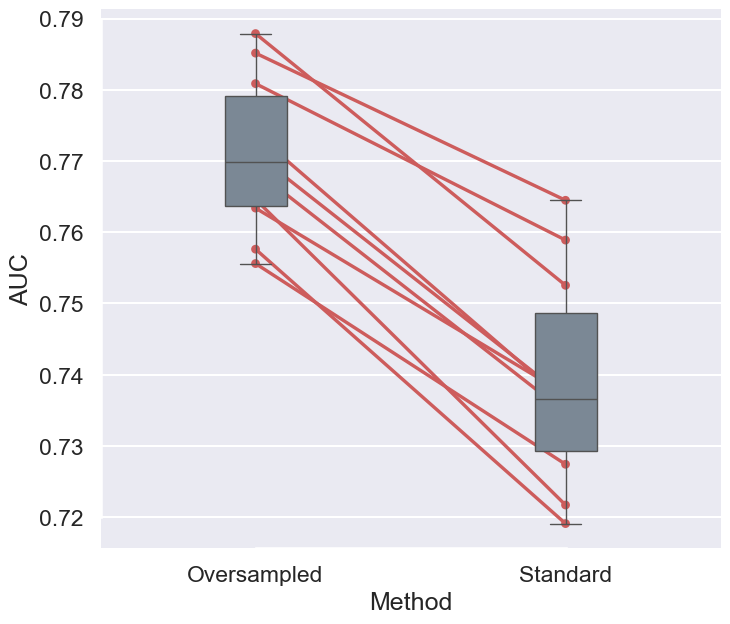

In [127]:
melt_df['cycle'] = list(range(0,10))+list(range(0,10))
plot_paired(data=melt_df,dv="AUC",within="Method",subject="cycle")
plt.xlabel('Method');

In [128]:
wilcoxon(res_df.Standard,res_df.Oversampled)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,0.0,two-sided,0.001953,-1.0,0.05


### Saving models

In [132]:
model = LGB(train_X,train_y)
model_rs = LGB(resample_X,resample_y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,022450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9195
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1638
[LightGBM] [Info] Start training from score -2,730963
[LightGBM] [Info] Start training from score -1,044130
[LightGBM] [Info] Start training from score -0,539833
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0,033010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9731
[LightGBM] [Info] Number of data points in the train set: 6870, number of used features: 1906
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612


In [140]:
#joblib.dump(model,'models/model_standard.pkl');
#joblib.dump(model_rs,'models/model_resampled.pkl');

In [6]:
model = joblib.load('models/model_standard.pkl')
model.get_params()['importance_type']

'split'